<a href="https://colab.research.google.com/github/eghrthrjdtsed/AB--/blob/master/Task9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B tests с Python




<a id="Libraries"></a>
##  Загрузка библиотек 

In [160]:
from scipy.stats import ttest_1samp

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')



##Mobile Games AB Testing with Cookie Cats

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, kstest, shapiro
import statsmodels.api as sm

In [162]:
df = pd.read_excel('/content/результаты А_B 9.xlsx')

In [163]:
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


Посмотрим данные по типу, нет ли ошибок при загрузке данных

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


Посмотрим средние значения

In [165]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


Посмотрим на наличия пустых строк

In [166]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Посмотрим на распределения контрольной и тестовой групп 

Всего ID

In [167]:
df['userid'].count()

90189

Проверим на уникальность

In [168]:
df['userid'].nunique()

90189

Двойные ID отсутствуют

In [169]:
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

Отличия в контрольной и тестовой группах минимальны

In [170]:
control = df.query('version == "gate_30"')

test = df.query('version == "gate_40"')

Применяем критерий Манна Уитни

In [171]:
from scipy.stats import mannwhitneyu
mw_stats = mannwhitneyu(x=control.sum_gamerounds.values, 
                        y=test.sum_gamerounds.values)

In [172]:
mw_stats

MannwhitneyuResult(statistic=1024331250.5, pvalue=0.05020880772044255)

pvalue=0.05 > alpha 0.05 H0 не отвергается, различий нет

Проведем T-тест

In [173]:
from scipy.stats import stats, ttest_ind

In [174]:
stats.ttest_ind(control.sum_gamerounds.values, test.sum_gamerounds.values, equal_var = False)

Ttest_indResult(statistic=0.8854374331270672, pvalue=0.37592438409326223)

Можем сделать вывод, что статистически значимых различий нет, pvalue=0.94 > alpha=0.05, Н0 не отвергается

Запустим тест Колмогорова-Смирнова 

In [175]:
print(kstest(control.sum_gamerounds, 'norm'))
print(kstest(test.sum_gamerounds, 'norm'))

KstestResult(statistic=0.8724176532867202, pvalue=0.0, statistic_location=2, statistic_sign=-1)
KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)


Распределение не нормальное

Посмотрим наглядно с помощью гистограммы

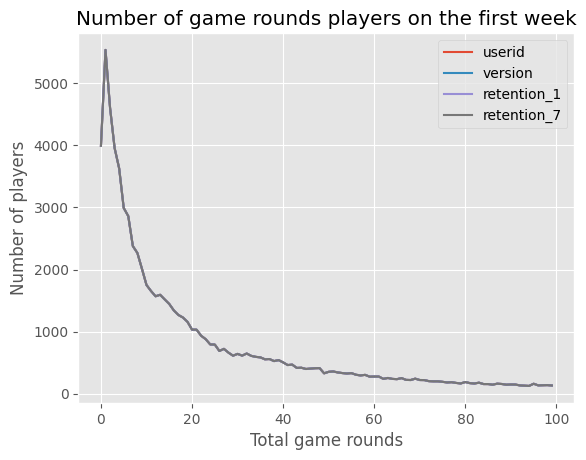

In [176]:

# Найдем сколько пользователь играет
plot_df = df.groupby('sum_gamerounds').count()

ax = plot_df[:100].plot()
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
ax.set_title('Number of game rounds players on the first week');

In [177]:
plt.style.use('ggplot')

Group_A = df[df.version == 'gate_30']
print(Group_A.head())

Group_B = df[df.version == 'gate_40']
print(Group_B.head())

bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A['sum_gamerounds'],
                                              bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B['sum_gamerounds'],
                                              bins=bins)).count())

    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3            0            0
1      337  gate_30              38            1            0
6     1066  gate_30               0            0            0
11    2101  gate_30               0            0            0
13    2179  gate_30              39            1            0
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165            1            0
3     483  gate_40               1            0            0
4     488  gate_40             179            1            1
5     540  gate_40             187            1            1
7    1444  gate_40               2            0            0


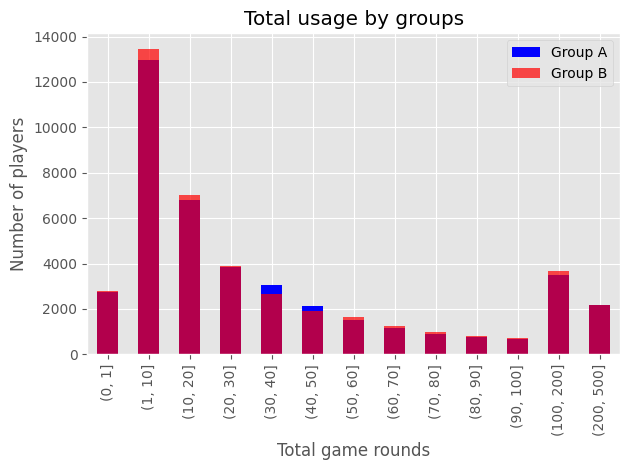

In [178]:

ax = plot_GA.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1,
                  title = 'Total usage by groups')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
plt.legend(['Group A', 'Group B'])
plt.tight_layout()
plt.grid(True)

График показывает, что между двумя версиями почти нет большой разницы.
Небольшие различия есть в пределах 30 - 40 сыгранных раундов.

Посмотрим какое удержание в течении 1 дня.

In [179]:
one_day = df.retention_1.sum()/df.retention_1.count()
print(str(one_day*100)+'%')

44.52095044850259%


Посмотрим какое удержание в течении 1 дня для групп.

In [180]:

oneday = df.retention_1.groupby(df.version).sum()/df.retention_1.groupby(df.version).count()
print(oneday*100)

version
gate_30    44.818792
gate_40    44.228275
Name: retention_1, dtype: float64


Обе версии имеют практически одинаковые результаты.
Четкого ответа стоит ли применять изменение мы не получили.
Для принятия решения воспользуемся Bootstrapp для более детального исследования.

In [181]:
boot_1d = []
for i in range(500):
  boot_mean = df.retention_1.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
print(boot_1d)

version       gate_30   gate_40
retention_1  0.450362  0.449093
retention_1  0.451462  0.442896
retention_1  0.451659  0.444698
retention_1  0.449435  0.443788
retention_1  0.445035  0.441153
...               ...       ...
retention_1  0.449135  0.439860
retention_1  0.449506  0.438595
retention_1  0.448372  0.443905
retention_1  0.448407  0.442621
retention_1  0.450923  0.443878

[500 rows x 2 columns]


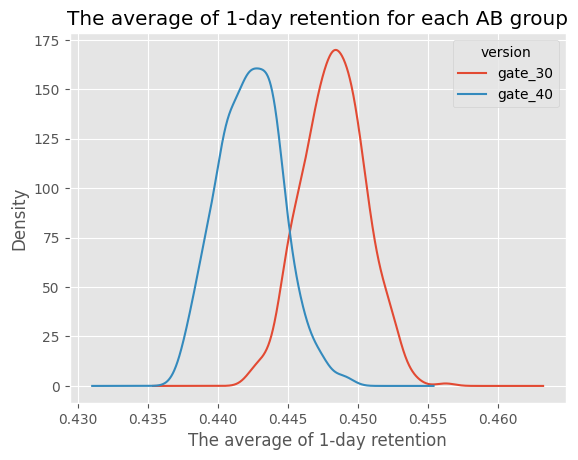

In [182]:
ax = boot_1d.plot.kde()
ax.set_title('The average of 1-day retention for each AB group')
ax.set_xlabel('The average of 1-day retention');

Увеличим разницу в удержании в течение 1 дня.

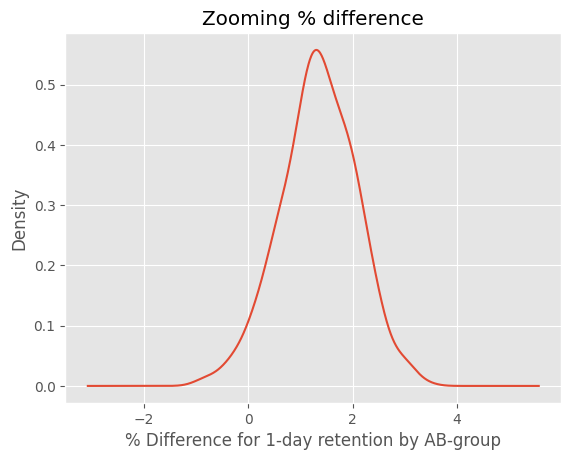

In [183]:
boot_1d['difference'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40']*100

ax = boot_1d['difference'].plot.kde()
ax.set_xlabel('% Difference for 1-day retention by AB-group')
ax.set_title('Zooming % difference');

Из графика видно, что наиболее вероятная разница 1-2% в пользу ворот на 30 уровне.

Посчитаем в скольки процентах случаев разница больше 0.

In [184]:

prob = (boot_1d['difference'] > 0).sum() / len(boot_1d['difference'])
print(str(prob*100)+'%')

96.39999999999999%


Вывод:
Существует высокая вероятность того, что удержание в течении 1 дня лучше, когда ворота находятся на уровне 30.

Дальше расчитаем удержание в течении 7 дней для двух AB групп.

In [185]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Здесь так же процент удержания выше у gate_30.

Для более точного расчета воспользуемся bootstrap-анализом.

In [186]:
boot_7d = []
for i in range(500):
  boot_mean = df.retention_7.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)
print(boot_7d.head())

boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100

version       gate_30   gate_40
retention_7  0.191009  0.177724
retention_7  0.189136  0.182290
retention_7  0.189484  0.180415
retention_7  0.187464  0.176804
retention_7  0.186064  0.178249


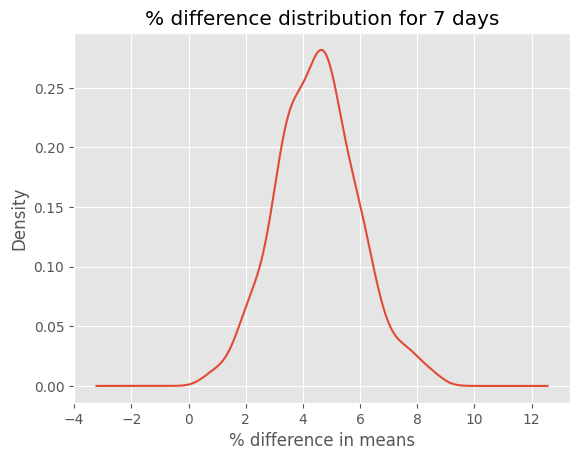

In [187]:
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel('% difference in means')
ax.set_title('% difference distribution for 7 days');

In [188]:
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])
print(str(prob*100)+'%')

100.0%


Вывод:
Наши иследования показали, что удержание в течении 7 дней выше, когда ворота ноходятся на уровне 30. Следовательно для удержания аудитории не рекомендуется перемещать варота с 30 уровня на 40.